In [4]:
import os
import warnings
import numpy as np
import scanpy as sc
import custom_tools
import anndata as ad
import seaborn as sns
import pandas as pd
import decoupler as dc
from pathlib import Path
from matplotlib import rcParams
import matplotlib.pyplot as plt
from dataset import TissueDataset
from pathlib import Path
import matplotlib
from dataset import TissueDataset, LungDataset


warnings.simplefilter(action='ignore')
sc.settings.verbosity = 0
# Set figure params
sc.set_figure_params(scanpy=True, facecolor="white", dpi=80, dpi_save=300)

In [5]:
df_merged_preprocessed_dataset = pd.read_csv("/home/rifaioglu/projects/GNNClinicalOutcomePrediction/data/Lung/raw/merged_preprocessed_dataset.csv")
df_merged_preprocessed_dataset

,sample_id,cell_id,cell_type,Location_Center_X,Location_Center_Y,area_pixels,CD117,CD11c,CD14,CD163,...,Sex,Age,BMI,Smoking Status,Pack Years,Stage,Progression,Death,Survival or loss (years),Predominant histological pattern
0,LUAD_D001,1,Cancer,159.174419,92.197674,86,0.0,0.0,1.930233,12.22093,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,8.386,3.0
1,LUAD_D001,2,Tc,187.880000,73.848000,125,0.0,0.0,0.000000,4.32000,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,8.386,3.0
2,LUAD_D001,3,Tc,131.333333,166.686275,51,0.0,0.0,0.000000,0.00000,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,8.386,3.0
3,LUAD_D001,4,Cancer,115.967213,132.327869,61,0.0,0.0,0.000000,0.00000,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,8.386,3.0
4,LUAD_D001,5,Endothelial cell,121.062500,140.421875,64,0.0,0.0,0.000000,0.00000,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,8.386,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2141850,LUAD_V60B,3927,Cancer,950.500000,744.000000,26,0.0,0.0,0.000000,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2141851,LUAD_V60B,3928,Cancer,958.666667,740.875000,24,0.0,0.0,0.000000,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2141852,LUAD_V60B,3929,Cancer,960.842105,312.842105,38,0.0,0.0,0.000000,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2141853,LUAD_V60B,3930,Cancer,994.500000,114.500000,32,0.0,0.0,0.000000,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [16]:
df = df_merged_preprocessed_dataset

# Compute mean CD163 per sample for each macrophage subtype
agg_df = (
    df
    .groupby(["sample_id", "cell_type"])["CD163"]
    .mean()
    .reset_index()
)

# Pivot to get columns: sample_id | Cl MAC | Alt MAC
pivot_df = agg_df.pivot(index="sample_id", columns="cell_type", values="CD163")

print(pivot_df)


cell_type     Alt MAC     B cell    Cancer    Cl MAC      Cl Mo   DCs cell  \
sample_id                                                                    
LUAD_D001   72.924767   1.197383  0.243723  7.414978   7.956472   0.000000   
LUAD_D002  105.309598  11.120151  0.172113  0.886924  12.400946   4.358971   
LUAD_D003  101.488618   5.060390  0.515824  3.952849   0.349519   0.000000   
LUAD_D004   78.039048   5.055949  0.214354  6.475598   5.052462  21.783019   
LUAD_D005   82.071623   5.945915  0.104577  4.878617  10.345744  18.410743   
...               ...        ...       ...       ...        ...        ...   
LUAD_V58B   46.663039   0.000000  0.067614  0.824027   0.799045   0.000000   
LUAD_V59A   71.410220  55.061391  0.404606  1.799539   3.700277        NaN   
LUAD_V59B   75.706088  30.083093  0.555524  7.946657  13.644860        NaN   
LUAD_V60A   71.809693   1.261225  0.044176  2.396832   1.580028   0.000000   
LUAD_V60B   63.341370   1.422724  0.022535  1.578311   0.565233 

In [17]:
from scipy.stats import mannwhitneyu, ttest_ind

cl_means = pivot_df["Cl MAC"].dropna()
alt_means = pivot_df["Alt MAC"].dropna()

# Mann-Whitney U test on sample-level means
mw = mannwhitneyu(cl_means, alt_means, alternative="two-sided")

# T-test
tt = ttest_ind(cl_means, alt_means, equal_var=False)

print("Mann–Whitney:", mw)
print("T-test:", tt)


Mann–Whitney: MannwhitneyuResult(statistic=0.0, pvalue=4.79971017462061e-176)
T-test: TtestResult(statistic=-92.32057382719064, pvalue=0.0, df=556.9711966556985)


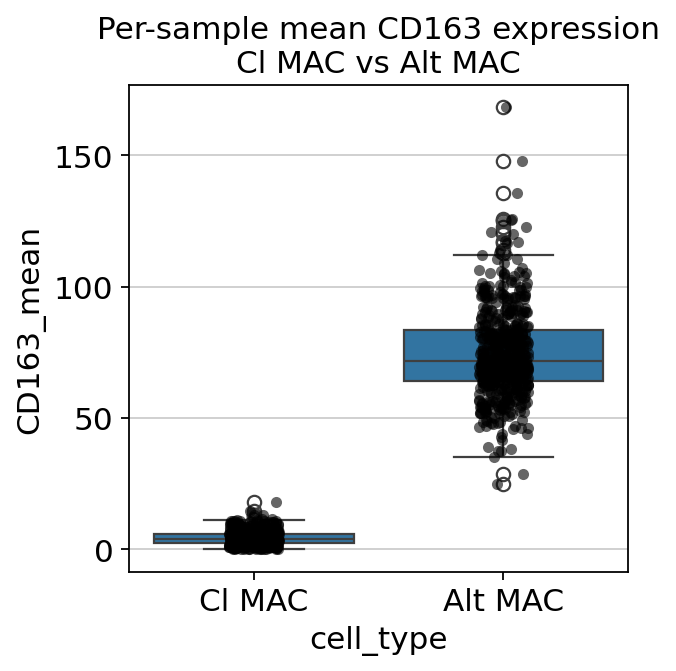

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare melted form for seaborn
plot_df = pivot_df.reset_index().melt(id_vars="sample_id",
                                      value_vars=["Cl MAC", "Alt MAC"],
                                      var_name="cell_type",
                                      value_name="CD163_mean")

sns.boxplot(data=plot_df, x="cell_type", y="CD163_mean")
sns.stripplot(data=plot_df, x="cell_type", y="CD163_mean", 
              color="black", alpha=0.6)

plt.title("Per-sample mean CD163 expression\nCl MAC vs Alt MAC")
plt.savefig("CD163_boxplot.pdf")
plt.show()


In [13]:
cl_mac = df_merged_preprocessed_dataset[
    df_merged_preprocessed_dataset["cell_type"] == "Cl MAC"
]

alt_mac = df_merged_preprocessed_dataset[
    df_merged_preprocessed_dataset["cell_type"] == "Alt MAC"
]


In [14]:
from scipy.stats import mannwhitneyu, ttest_ind

# Non-parametric test
mw = mannwhitneyu(cl_mac["CD163"], alt_mac["CD163"], alternative="two-sided")
print("Mann-Whitney U test:", mw)

# Optional: t-test (if distribution looks normal)
tt = ttest_ind(cl_mac["CD163"], alt_mac["CD163"], equal_var=False)
print("T-test:", tt)


Mann-Whitney U test: MannwhitneyuResult(statistic=198625458.0, pvalue=0.0)
T-test: TtestResult(statistic=-363.5228021378316, pvalue=0.0, df=53111.473942107004)


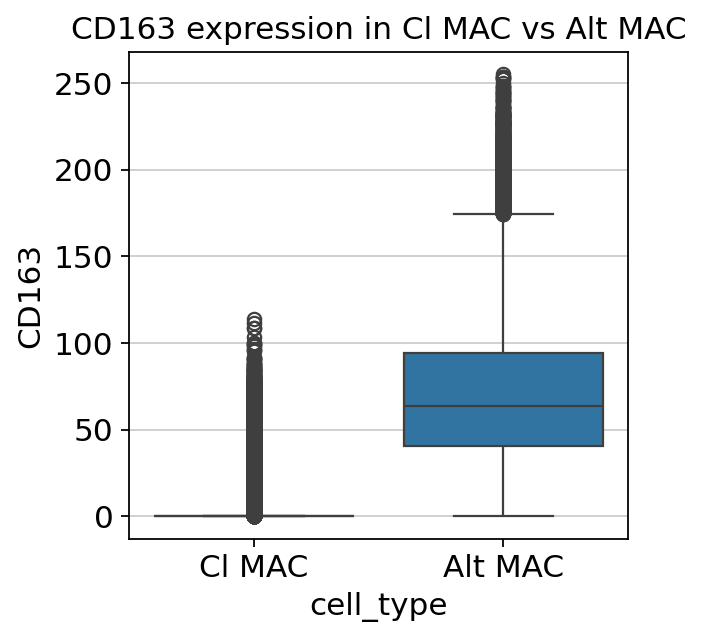

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

subset = df_merged_preprocessed_dataset[
    df_merged_preprocessed_dataset["cell_type"].isin(["Cl MAC", "Alt MAC"])
]

sns.boxplot(data=subset, x="cell_type", y="CD163")
plt.title("CD163 expression in Cl MAC vs Alt MAC")
plt.show()


In [6]:
ct_dict = {}
for ind, row in df_merged_preprocessed_dataset.iterrows():
    s_id = row["sample_id"]
    if f"Lung_Lung_{s_id}_{s_id}" in ct_dict.keys():
        
        ct_dict[f"Lung_Lung_{s_id}_{s_id}"].append(row["cell_type"])
    else:
        ct_dict[f"Lung_Lung_{s_id}_{s_id}"] = [row["cell_type"]]


In [7]:
# Read json file
# exp_name = "GATV2_NegativeLogLikelihood_month_04-12-2023"
# job_id = "fombnNMthdocYhDPmAjaBQ"
# exp_name = "progression_hpo_full_training"
exp_name = "Lung"
dataset_name = "Lung"
# job_id = "2mYvWJwUarIJkw0vvUbl3Q"


# job_id = "Mx08rzAp6WZs_yDoXS1Fuw"  # This is the best model trained fully on the Lung dataset named as Lung
job_id = "Lung"

PLT_PATH = f"../plots/analysis/{exp_name}_{job_id}"
Path(PLT_PATH).mkdir(parents=True, exist_ok=True)
device =  custom_tools.get_device()
args  = custom_tools.load_json(f"../models/{exp_name}/{job_id}.json")


print(args)
# args["num_node_features"] = 33
deg = None
if "PNA" in exp_name:
    deg = custom_tools.load_pickle(f"../models/{exp_name}/{job_id}_deg.pckl")
model = custom_tools.load_model(f"{job_id}_SD", path = f"../models/{exp_name}", model_type = "SD", args = args, deg=deg, label_type = "classification", device=device)
dataset = LungDataset(os.path.join(f"../data/{dataset_name}"),  "Progression")

adata_concat = []
for adata_fl in os.listdir(f"/home/rifaioglu/projects/GNNClinicalOutcomePrediction/data/out_data/adatafiles/Lung"):
    if  adata_fl.endswith("lr-0.01.h5ad"):
        adata = sc.read_h5ad(f"/home/rifaioglu/projects/GNNClinicalOutcomePrediction/data/out_data/adatafiles/Lung/{adata_fl}")
        idx = adata_fl.split("_lr")[0]
        idx = idx.rsplit("_", 1)[0]
        print(idx)
        adata.obs["cell_type"] = ct_dict[idx]
        adata_concat.append(adata)
adata_exp = ad.concat(adata_concat)
adata_exp.obs_names_make_unique()

Seed set to 42
Seed set to 42


GPU is available on this device!
{'dataset_name': 'Lung', 'model': 'GATV2', 'lr': 0.00020297336665514866, 'bs': 32, 'dropout': 0.11361074517675404, 'epoch': 80, 'num_of_gcn_layers': 2, 'num_of_ff_layers': 2, 'gcn_h': 32, 'fcl': 64, 'en': 'progression_hpo_full_training', 'weight_decay': 1.0802059900326831e-05, 'factor': 0.34242097974773783, 'patience': 7, 'min_lr': 3.215465058067676e-05, 'aggregators': ['sum', 'mean'], 'scalers': ['amplification', 'identity'], 'heads': 2, 'fold': False, 'full_training': True, 't_v_t': False, 'label': 'Progression', 'loss': 'BCEWithLogitsLoss', 'unit': 'month', 'gpu_id': 0, 'str': "aggregators:['sum', 'mean']-bs:32-dataset_name:Lung-dropout:0.11361074517675404-en:progression_hpo_full_training-epoch:80-factor:0.34242097974773783-fcl:64-fold:False-full_training:True-gcn_h:32-gpu_id:0-heads:2-label:Progression-loss:BCEWithLogitsLoss-lr:0.00020297336665514866-min_lr:3.215465058067676e-05-model:GATV2-num_of_ff_layers:2-num_of_gcn_layers:2-patience:7-scalers:[

In [11]:
adata_exp.obs

,clinical_type,img_id,osmonth,importance,importance_hard,cell_type
0,4.0,LUAD_D154_LUAD_D154,0.142,0.116238,False,Cancer
1,4.0,LUAD_D154_LUAD_D154,0.142,0.121666,False,Cancer
2,4.0,LUAD_D154_LUAD_D154,0.142,0.073951,False,Cancer
3,4.0,LUAD_D154_LUAD_D154,0.142,0.114149,False,Cancer
4,4.0,LUAD_D154_LUAD_D154,0.142,0.163281,False,Cancer
...,...,...,...,...,...,...
5283-40,3.0,LUAD_D034_LUAD_D034,2.141,0.204072,True,Cancer
5284-40,3.0,LUAD_D034_LUAD_D034,2.141,0.117806,False,Cancer
5285-40,3.0,LUAD_D034_LUAD_D034,2.141,0.096111,False,Tc
5286-39,3.0,LUAD_D034_LUAD_D034,2.141,0.047763,False,Cancer


In [7]:
adata_exp.obs.img_id.unique()

['LUAD_D154_LUAD_D154', 'LUAD_D150_LUAD_D150', 'LUAD_D293_LUAD_D293', 'LUAD_D107_LUAD_D107', 'LUAD_D253_LUAD_D253', ..., 'LUAD_D148_LUAD_D148', 'LUAD_D309_LUAD_D309', 'LUAD_D014_LUAD_D014', 'LUAD_D272_LUAD_D272', 'LUAD_D034_LUAD_D034']
Length: 405
Categories (405, object): ['LUAD_D001_LUAD_D001', 'LUAD_D002_LUAD_D002', 'LUAD_D003_LUAD_D003', 'LUAD_D004_LUAD_D004', ..., 'LUAD_D414_LUAD_D414', 'LUAD_D415_LUAD_D415', 'LUAD_D416_LUAD_D416', 'LUAD_V20B_LUAD_V20B']

In [12]:
important = df[df["importance_hard"] == True]


Mann-Whitney U test p-value: 7.972087423153025e-09
Cell density is LOWER in progression.


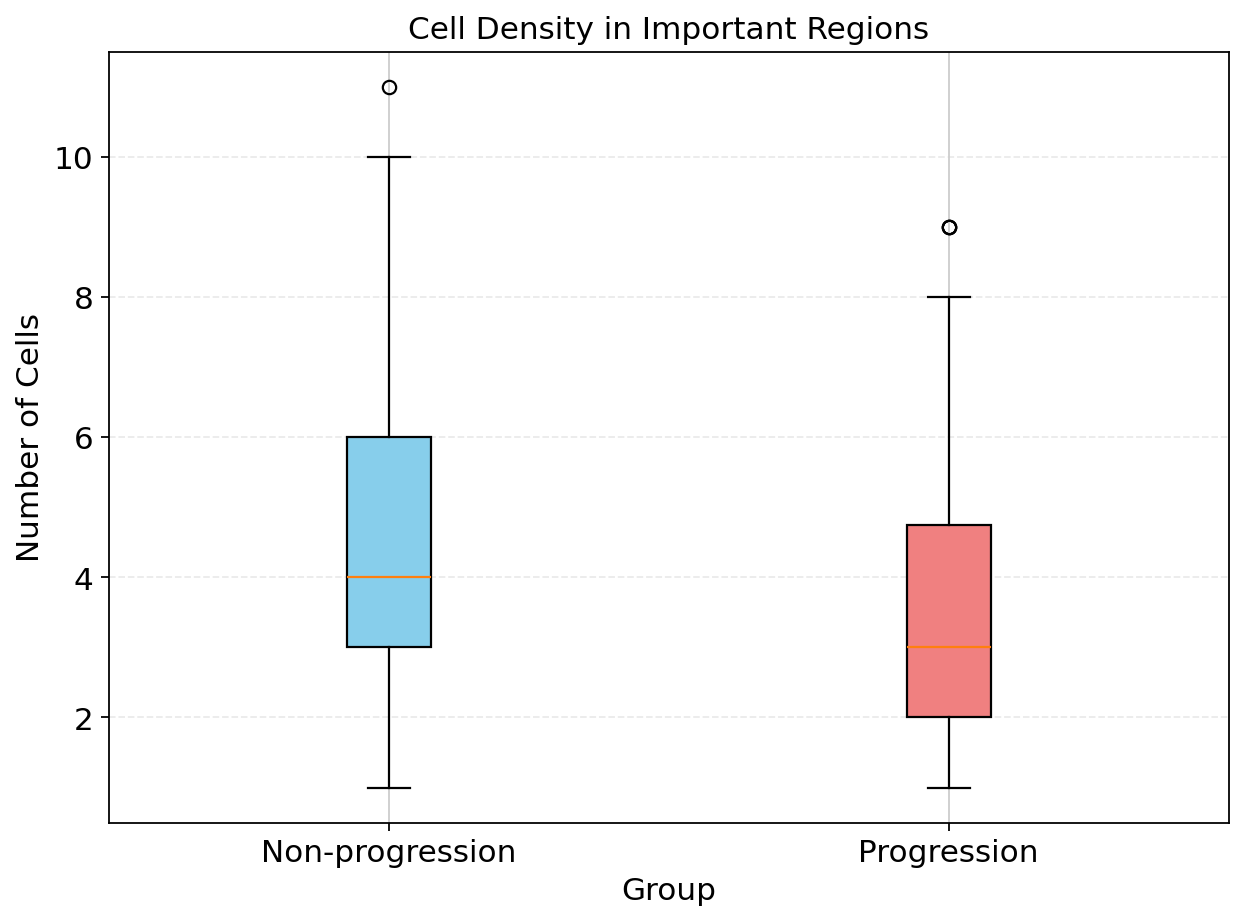

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# ---------------------------------------------------------
# 1. Simulate dataset (replace this section with your own df)
# ---------------------------------------------------------
np.random.seed(42)

n = 4000
df = pd.DataFrame({
    "img_id": np.random.choice([f"IMG_{i}" for i in range(200)], n),
    "progression": np.random.choice([0, 1], n, p=[0.6, 0.4]),
    "importance_hard": np.random.choice([True, False], n, p=[0.4, 0.6]),
    "cell_type": np.random.choice(
        ["Cancer", "Mast cell", "Cl MAC", "TCELL", "Bcell"], n
    ),
})

# ---------------------------------------------------------
# 2. Filter only important regions
# ---------------------------------------------------------
important = df[df["importance_hard"] == True]

# ---------------------------------------------------------
# 3. Compute number of cells per image per group
# ---------------------------------------------------------
cell_counts = (
    important.groupby(["img_id", "progression"])
    .size()
    .reset_index(name="cell_count")
)

# Extract groups
non_prog = cell_counts[cell_counts.progression == 0]["cell_count"]
prog = cell_counts[cell_counts.progression == 1]["cell_count"]

# ---------------------------------------------------------
# 4. Statistical test
# ---------------------------------------------------------
stat, p = mannwhitneyu(non_prog, prog, alternative="two-sided")
print("Mann-Whitney U test p-value:", p)

if prog.mean() > non_prog.mean():
    print("Cell density is HIGHER in progression.")
else:
    print("Cell density is LOWER in progression.")

# ---------------------------------------------------------
# 5. Box plot with colors
# ---------------------------------------------------------
plt.figure(figsize=(8, 6))

# colored boxes
box = plt.boxplot(
    [non_prog, prog],
    labels=["Non-progression", "Progression"],
    patch_artist=True
)

colors = ["skyblue", "lightcoral"]  # custom colors
for patch, color in zip(box["boxes"], colors):
    patch.set_facecolor(color)

plt.title("Cell Density in Important Regions")
plt.xlabel("Group")
plt.ylabel("Number of Cells")
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


In [14]:
imp_threshold = 0.75
# Get the importance of the nodes
node_importance = np.array(adata_exp.obs["importance"])
node_imp_thr = np.quantile(node_importance, imp_threshold)

importances_hard_v2 = np.array(node_importance > node_imp_thr, dtype="str")
# print("importances_hard", importances_hard)
importances_hard_v2 = pd.Series(importances_hard_v2, dtype="category")
# print(importances_hard)
adata_exp.obs["importance_hard"] = importances_hard_v2.values



In [15]:

import embeddings
emd, related_data = embeddings.get_intermediate_embeddings_for_dataset(model, dataset, batch_size=1)
emd_cnv, related_data_cnv = embeddings.get_intermediate_embeddings_for_dataset(model, dataset, mode="CNV", batch_size=1)


In [16]:
embedding_arr = np.array(emd[0])
pid_list, img_id_list, osmonth_lst,  clinical_type_lst, disease_stage_lst, progression_lst= [], [], [], [], [], []
for data in related_data:
    print(data)
    # pid_list.append(str(data.p_id[0]))
    osmonth_lst.append(data.osmonth.item())
    img_id_list.append(data.img_id[0])
    clinical_type_lst.append(data.clinical_type[0])
    disease_stage_lst.append(str(data.disease_stage.item()))
    progression_lst.append(data.y.item())

embedding_arr.shape

DataBatch(x=[4357, 18], edge_index=[2, 25394], y=[1], pos=[4357, 2], osmonth=[1], sample_id=[1], img_id=[1], clinical_type=[1], disease_stage=[1], batch=[4357], ptr=[2])
DataBatch(x=[4260, 18], edge_index=[2, 24844], y=[1], pos=[4260, 2], osmonth=[1], sample_id=[1], img_id=[1], clinical_type=[1], disease_stage=[1], batch=[4260], ptr=[2])
DataBatch(x=[3949, 18], edge_index=[2, 23024], y=[1], pos=[3949, 2], osmonth=[1], sample_id=[1], img_id=[1], clinical_type=[1], disease_stage=[1], batch=[3949], ptr=[2])
DataBatch(x=[3495, 18], edge_index=[2, 20368], y=[1], pos=[3495, 2], osmonth=[1], sample_id=[1], img_id=[1], clinical_type=[1], disease_stage=[1], batch=[3495], ptr=[2])
DataBatch(x=[5274, 18], edge_index=[2, 30760], y=[1], pos=[5274, 2], osmonth=[1], sample_id=[1], img_id=[1], clinical_type=[1], disease_stage=[1], batch=[5274], ptr=[2])
DataBatch(x=[5797, 18], edge_index=[2, 33820], y=[1], pos=[5797, 2], osmonth=[1], sample_id=[1], img_id=[1], clinical_type=[1], disease_stage=[1], bat

(416, 64)

In [17]:
adata_emb = ad.AnnData(embedding_arr)
adata_emb.var_names = [f"emb_{i}" for i in range(embedding_arr.shape[1])]
adata_emb.obs_names = img_id_list
adata_emb.obs["img_id"] = img_id_list
adata_emb.obs["img_id"] = adata_emb.obs["img_id"].astype("category")
adata_emb.obs["osmonth"] = osmonth_lst
adata_emb.obs["clinical_type"] = clinical_type_lst
adata_emb.obs["disease_stage"] = disease_stage_lst
adata_emb.obs["progression"] = progression_lst  

In [18]:
sc.tl.pca(adata_emb, svd_solver='arpack', random_state=42)
sc.pp.neighbors(adata_emb)
sc.tl.leiden(adata_emb, key_added = "leiden", resolution=1)
sc.tl.umap(adata_emb, random_state=42)

... storing 'clinical_type' as categorical
... storing 'disease_stage' as categorical


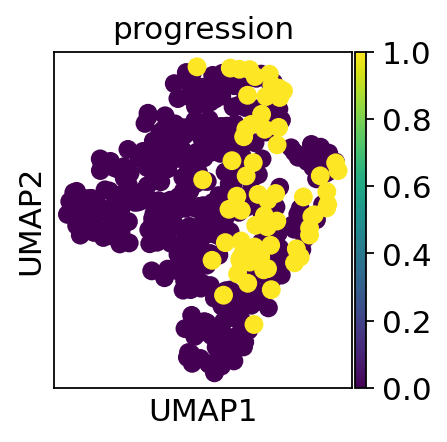

In [19]:
cmap = sns.palettes.get_colormap("tab20")
color_dict = dict()

for ind, clust_index in enumerate(adata_emb.obs["leiden"].cat.categories):
    color_dict[clust_index] = cmap.colors[ind]

rcParams['figure.figsize']=(3,3)
sc.pl.umap(adata_emb, color=["progression"], palette=color_dict, show=False, legend_loc = 'on data') #, save="_jacksonfisher_embedding_boxplot.pdf")
plt.tight_layout()
plt.savefig(os.path.join(PLT_PATH, "lung_embedding_boxplot.pdf"))
plt.show()

In [20]:
progression_map = (
    adata_emb.obs
    .drop_duplicates(subset='img_id')  # keep first occurrence
    .set_index('img_id')['progression']
)
adata_exp.obs['progression'] = adata_exp.obs['img_id'].map(progression_map).astype('category')


In [37]:
adata_exp.obs.to_csv("adata_exp.csv")

In [30]:
import pandas as pd

# If your AnnData is named adata_exp
df = adata_exp.obs.copy()

# 1. Filter only important regions
important = df[df["importance_hard"] == True]

# 2. Count number of cells for each image in important regions
cell_count_per_image = (
    important.groupby(["img_id"])
)

cell_count_per_image = (
    important.groupby(["img_id", "progression"])
    .size()
    .reset_index(name="num_cells_important")
)


In [33]:
df = adata_exp.obs.copy()
df

,clinical_type,img_id,osmonth,importance,importance_hard,cell_type,progression
0,4.0,LUAD_D154_LUAD_D154,0.142,0.116238,False,Cancer,0
1,4.0,LUAD_D154_LUAD_D154,0.142,0.121666,False,Cancer,0
2,4.0,LUAD_D154_LUAD_D154,0.142,0.073951,False,Cancer,0
3,4.0,LUAD_D154_LUAD_D154,0.142,0.114149,False,Cancer,0
4,4.0,LUAD_D154_LUAD_D154,0.142,0.163281,True,Cancer,0
...,...,...,...,...,...,...,...
5283-40,3.0,LUAD_D034_LUAD_D034,2.141,0.204072,True,Cancer,0
5284-40,3.0,LUAD_D034_LUAD_D034,2.141,0.117806,False,Cancer,0
5285-40,3.0,LUAD_D034_LUAD_D034,2.141,0.096111,False,Tc,0
5286-39,3.0,LUAD_D034_LUAD_D034,2.141,0.047763,False,Cancer,0


In [36]:
df.groupby(["img_id", "progression"]).count()


clinical_type  osmonth  importance  \
img_id              progression                                       
LUAD_D001_LUAD_D001 0                     4517     4517        4517   
                    1                        0        0           0   
LUAD_D002_LUAD_D002 0                        0        0           0   
                    1                     3134     3134        3134   
LUAD_D003_LUAD_D003 0                     3344     3344        3344   
...                                        ...      ...         ...   
LUAD_D415_LUAD_D415 1                        0        0           0   
LUAD_D416_LUAD_D416 0                     2886     2886        2886   
                    1                        0        0           0   
LUAD_V20B_LUAD_V20B 0                     3781        0        3781   
                    1                        0        0           0   

                                 importance_hard  cell_type  
img_id              progression                              
LUAD_D001_LUAD_D001 0                       4517       4517  
                    1                          0          0  
LUAD_D002_LUAD_D002 0                          0          0  
                    1                       3134       3134  
LUAD_D003_LUAD_D003 0                       3344       3344  
...                                          ...        ...  
LUAD_D415_LUAD_D415 1                          0          0  
LUAD_D416_LUAD_D416 0                       2886       2886  
                    1                          0          0  
LUAD_V20B_LUAD_V20B 0                       3781       3781  
                    1                          0          0  

[810 rows x 5 columns]

In [22]:
from scipy.stats import mannwhitneyu

group0 = density_per_image.loc[density_per_image.progression == 0, "cell_density"]
group1 = density_per_image.loc[density_per_image.progression == 1, "cell_density"]

stat, p = mannwhitneyu(group0, group1, alternative='two-sided')

print("Mann-Whitney U p-value:", p)


Mann-Whitney U p-value: 1.0


In [ ]:
# In decoupler 2.1.2, get_pseudobulk was moved to pp.pseudobulk
# Parameters min_cells and min_counts were removed
# TODO: need to update the other notebooks
pdata_imp_vs_unimp = dc.pp.pseudobulk(
    adata_exp,
    sample_col='img_id',
    groups_col='importance_hard',
    mode='mean',
    empty=False  # Set to False to keep empty observations/features
)


In [ ]:
adata_exp[adata_exp.obs['img_id'] == "LUAD_D086_LUAD_D086"].obs['progression']

In [ ]:

# create a new pseudobulk anndata with only important nodes
pdata_imp = pdata_imp_vs_unimp[pdata_imp_vs_unimp.obs_names.str.contains("True"),:].copy()
new_obs_names = [obs_n.split("_")[0] for obs_n in pdata_imp.obs_names]
# pdata_imp.obs_names = new_obs_names
# pdata_imp.obsm["X_umap"] = adata_emb.obsm["X_umap"]

In [ ]:
sc.tl.rank_genes_groups(pdata_imp, groupby=f"progression", method="wilcoxon", key_added = f"wilcoxon_all")

In [ ]:
rcParams['figure.figsize']=(4,4)
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'axes.labelsize' : 10}) 

sc.pl.rank_genes_groups(pdata_imp, n_genes=5, sharey=False,  key=f"wilcoxon_all", show=True, groupby="leiden")
plt.tight_layout()
plt.show()
rcParams['figure.figsize']=(4,3)
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'axes.labelsize' : 10}) 
sc.pl.rank_genes_groups(pdata_imp, n_genes=5, standard_scale='var', key=f"wilcoxon_all", figsize = (8,8), show=False, groupby="progression")
sc.pl.rank_genes_groups_dotplot(pdata_imp, n_genes=5, standard_scale='var', key=f"wilcoxon_all", figsize = (8,8), show=False, groupby="progression")
plt.gcf().subplots_adjust(top = 0.60, bottom=0.50)
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_psedu_imp_ranking.pdf"), dpi=300)
plt.show()


In [ ]:
img_pid = "LUAD_D001_LUAD_D001"
path = "/home/rifaioglu/projects/GNNClinicalOutcomePrediction/data/Lung"
with open(os.path.join(path, "raw", f'{img_pid}_features.pickle'), 'rb') as handle:
                    feature_arr = pickle.load(handle)
                    feature_arr = np.array(feature_arr)
with open(os.path.join(path, "raw", f'{img_pid}_edge_index_length.pickle'), 'rb') as handle:
    edge_index_arr, edge_length_arr = pickle.load(handle)
    edge_index_arr = np.array(edge_index_arr)

with open(os.path.join(path, "raw", f'{img_pid}_ct_class.pickle'), 'rb') as handle:
    ct_class_arr = pickle.load(handle)
    ct_class_arr = np.array(ct_class_arr)

with open(os.path.join(path, "raw", f'{img_pid}_coordinates.pickle'), 'rb') as handle:
    coordinates_arr = pickle.load(handle)
    coordinates_arr = np.array(coordinates_arr)

with open(os.path.join(path, "raw", f'{img_pid}_clinical_info.pickle'), 'rb') as handle:
    clinical_info_dict = pickle.load(handle)
    clinical_info_dict = np.array(clinical_info_dict)